In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from collections import Counter
import re
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download and prepare IMDB dataset
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDB dataset
print("Loading IMDB dataset...")
(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Convert to lists
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for text, label in train_data:
    train_texts.append(text.numpy().decode('utf-8'))
    train_labels.append(label.numpy())

for text, label in test_data:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

print(f"Train samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")

# Text preprocessing
class TextPreprocessor:
    def __init__(self, max_vocab_size=10000, max_length=512):
        self.max_vocab_size = max_vocab_size
        self.max_length = max_length
        self.vocab = {}
        self.inverse_vocab = {}

    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    def build_vocab(self, texts):
        # Special tokens
        self.vocab = {'<PAD>': 0, '<UNK>': 1, '<CLS>': 2, '<SEP>': 3, '<MASK>': 4}

        # Count word frequencies
        word_counts = Counter()
        for text in texts:
            cleaned_text = self.clean_text(text)
            words = cleaned_text.split()
            word_counts.update(words)

        # Add most common words to vocabulary
        most_common = word_counts.most_common(self.max_vocab_size - len(self.vocab))
        for idx, (word, _) in enumerate(most_common):
            self.vocab[word] = len(self.vocab)

        # Create inverse vocabulary
        self.inverse_vocab = {v: k for k, v in self.vocab.items()}
        print(f"Vocabulary size: {len(self.vocab)}")

    def encode(self, text, add_special_tokens=True):
        cleaned_text = self.clean_text(text)
        words = cleaned_text.split()

        # Truncate if necessary
        if len(words) > self.max_length - 2:  # -2 for CLS and SEP tokens
            words = words[:self.max_length - 2]

        # Convert words to indices
        indices = []
        if add_special_tokens:
            indices.append(self.vocab['<CLS>'])

        for word in words:
            indices.append(self.vocab.get(word, self.vocab['<UNK>']))

        if add_special_tokens:
            indices.append(self.vocab['<SEP>'])

        return indices

    def decode(self, indices):
        words = []
        for idx in indices:
            if idx in self.inverse_vocab:
                word = self.inverse_vocab[idx]
                if word not in ['<PAD>', '<CLS>', '<SEP>']:
                    words.append(word)
        return ' '.join(words)

# Create preprocessor and build vocabulary
preprocessor = TextPreprocessor(max_vocab_size=10000, max_length=256)
preprocessor.build_vocab(train_texts)

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Encode text
        encoded = self.preprocessor.encode(text)

        return {
            'input_ids': torch.tensor(encoded, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Collate function for padding
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])

    # Pad sequences
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)

    # Create attention mask
    attention_mask = (input_ids != 0).float()

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Create datasets and dataloaders
train_dataset = IMDBDataset(train_texts, train_labels, preprocessor)
test_dataset = IMDBDataset(test_texts, test_labels, preprocessor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_length=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

Using device: cuda
Loading IMDB dataset...
Train samples: 25000
Test samples: 25000
Vocabulary size: 10000


In [11]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_length=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Updated Multi-Head Attention that handles both padding and causal masks properly
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        # Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            # Check if mask needs to be expanded for heads
            if mask.dim() == 2:  # (batch, seq_len) - padding mask
                mask = mask.unsqueeze(1).unsqueeze(1)  # (batch, 1, 1, seq_len)
                mask = mask.expand(batch_size, self.n_heads, seq_len, seq_len)
            elif mask.dim() == 3:  # (batch, seq_len, seq_len) - causal mask
                mask = mask.unsqueeze(1)  # (batch, 1, seq_len, seq_len)

            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context = torch.matmul(attention_weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )

        output = self.W_o(context)

        return output, attention_weights




# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context = torch.matmul(attention_weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )

        output = self.W_o(context)

        return output, attention_weights

# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * correct / total
        })

    return total_loss / len(dataloader), correct / total

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary'
    )

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

In [12]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, _ = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

# Encoder-Only Model (BERT-like)
class EncoderOnlyModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=6, d_ff=1024,
                 max_length=512, num_classes=2, dropout=0.1):
        super(EncoderOnlyModel, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_length)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # Embedding and positional encoding
        x = self.embedding(input_ids) * np.sqrt(self.d_model)
        x = x.transpose(0, 1)  # (seq_len, batch, d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x.transpose(0, 1), attention_mask)
            x = x.transpose(0, 1)

        x = x.transpose(0, 1)  # (batch, seq_len, d_model)

        # Use CLS token representation for classification
        cls_representation = x[:, 0, :]
        logits = self.classifier(cls_representation)

        return logits

# Model configuration
model_config = {
    'vocab_size': len(preprocessor.vocab),
    'd_model': 256,
    'n_heads': 8,
    'n_layers': 4,
    'd_ff': 1024,
    'max_length': 256,
    'num_classes': 2,
    'dropout': 0.1
}

# Training configuration
training_config = {
    'learning_rate': 2e-4,
    'num_epochs': 10,
    'batch_size': 32
}

# Initialize encoder model
encoder_model = EncoderOnlyModel(**model_config).to(device)
print(f"Encoder model parameters: {sum(p.numel() for p in encoder_model.parameters()):,}")

# Loss and optimizer for encoder
criterion = nn.CrossEntropyLoss()
encoder_optimizer = optim.Adam(encoder_model.parameters(), lr=training_config['learning_rate'])

# Training function
def train_model(model, optimizer, model_name):
    print(f"\nTraining {model_name}...")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0

    for epoch in range(training_config['num_epochs']):
        print(f"\nEpoch {epoch+1}/{training_config['num_epochs']}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluate
        val_metrics = evaluate(model, test_loader, criterion, device)
        val_losses.append(val_metrics['loss'])
        val_accuracies.append(val_metrics['accuracy'])

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}, Val F1: {val_metrics['f1']:.4f}")

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy
    }

# Train encoder model
encoder_results = train_model(encoder_model, encoder_optimizer, "Encoder-Only")

Encoder model parameters: 5,719,554

Training Encoder-Only...

Epoch 1/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.60it/s]


Train Loss: 0.5029, Train Acc: 0.7438
Val Loss: 0.4042, Val Acc: 0.8131
Val Precision: 0.8569, Val Recall: 0.7517, Val F1: 0.8009

Epoch 2/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]


Train Loss: 0.3892, Train Acc: 0.8252
Val Loss: 0.4162, Val Acc: 0.8166
Val Precision: 0.7610, Val Recall: 0.9231, Val F1: 0.8343

Epoch 3/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.24it/s]


Train Loss: 0.3535, Train Acc: 0.8462
Val Loss: 0.3604, Val Acc: 0.8374
Val Precision: 0.8558, Val Recall: 0.8117, Val F1: 0.8331

Epoch 4/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.53it/s]


Train Loss: 0.3336, Train Acc: 0.8559
Val Loss: 0.3627, Val Acc: 0.8410
Val Precision: 0.8073, Val Recall: 0.8958, Val F1: 0.8493

Epoch 5/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]


Train Loss: 0.3130, Train Acc: 0.8677
Val Loss: 0.3769, Val Acc: 0.8363
Val Precision: 0.8890, Val Recall: 0.7686, Val F1: 0.8244

Epoch 6/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]


Train Loss: 0.2989, Train Acc: 0.8705
Val Loss: 0.3997, Val Acc: 0.8314
Val Precision: 0.9024, Val Recall: 0.7432, Val F1: 0.8151

Epoch 7/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]


Train Loss: 0.2842, Train Acc: 0.8832
Val Loss: 0.3727, Val Acc: 0.8514
Val Precision: 0.8667, Val Recall: 0.8306, Val F1: 0.8482

Epoch 8/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


Train Loss: 0.2712, Train Acc: 0.8853
Val Loss: 0.3512, Val Acc: 0.8520
Val Precision: 0.8632, Val Recall: 0.8366, Val F1: 0.8497

Epoch 9/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]


Train Loss: 0.2609, Train Acc: 0.8921
Val Loss: 0.3687, Val Acc: 0.8458
Val Precision: 0.8752, Val Recall: 0.8066, Val F1: 0.8395

Epoch 10/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s]


Train Loss: 0.2506, Train Acc: 0.8951
Val Loss: 0.3609, Val Acc: 0.8522
Val Precision: 0.8349, Val Recall: 0.8780, Val F1: 0.8559


In [18]:
import torch
import torch.nn as nn
import numpy as np

# MultiHeadAttention - اصلاح‌شده
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.size()

        Q = self.W_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (batch_size, 1, seq_len, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, V)  # (batch_size, n_heads, seq_len, d_k)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.W_o(context)
        return output, attn_weights

# FeedForward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# DecoderLayer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# DecoderOnlyModel
class DecoderOnlyModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=6, d_ff=1024,
                 max_length=512, num_classes=2, dropout=0.1):
        super(DecoderOnlyModel, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_length, d_model)

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        x = self.embedding(input_ids) * np.sqrt(self.d_model)
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
        x = x + self.pos_embedding(positions)
        x = self.dropout(x)

        # Causal mask: only allow attending to previous tokens
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=device)).unsqueeze(0).expand(batch_size, -1, -1)

        if attention_mask is not None:
            padding_mask = attention_mask.unsqueeze(1).expand(-1, seq_len, -1)
            mask = causal_mask * padding_mask
        else:
            mask = causal_mask

        for layer in self.decoder_layers:
            x = layer(x, mask)

        x = self.norm(x)

        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1, dtype=torch.long) - 1
            lengths = torch.clamp(lengths, min=0, max=seq_len-1)
            last_tokens = x[torch.arange(batch_size, device=device), lengths]
        else:
            last_tokens = x[:, -1, :]

        logits = self.classifier(last_tokens)
        return logits






In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim

# Training step for one epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * correct / total
        })

    return total_loss / len(dataloader), correct / total


# Evaluation on test set
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary'
    )

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }


# Full training loop
def train_model(model, optimizer, model_name, train_loader, test_loader, criterion, training_config, device):
    print(f"\nTraining {model_name}...")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0

    for epoch in range(training_config['num_epochs']):
        print(f"\nEpoch {epoch+1}/{training_config['num_epochs']}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_metrics = evaluate(model, test_loader, criterion, device)
        val_losses.append(val_metrics['loss'])
        val_accuracies.append(val_metrics['accuracy'])

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}, Val F1: {val_metrics['f1']:.4f}")

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy
    }


In [20]:
# فرض بر این است که موارد زیر از قبل وجود دارند:
# preprocessor, train_loader, test_loader, device

# پیکربندی مدل
model_config = {
    'vocab_size': len(preprocessor.vocab),
    'd_model': 256,
    'n_heads': 8,
    'n_layers': 4,
    'd_ff': 1024,
    'max_length': 256,
    'num_classes': 2,
    'dropout': 0.1
}

# پیکربندی آموزش
training_config = {
    'learning_rate': 2e-4,
    'num_epochs': 10,
    'batch_size': 32
}

# ایجاد مدل دیکودر
decoder_model = DecoderOnlyModel(**model_config).to(device)
print(f"Decoder model parameters: {sum(p.numel() for p in decoder_model.parameters()):,}")

# بهینه‌ساز و تابع هزینه
decoder_optimizer = optim.Adam(decoder_model.parameters(), lr=training_config['learning_rate'])
criterion = nn.CrossEntropyLoss()

# آموزش مدل
decoder_results = train_model(
    decoder_model, decoder_optimizer, "Decoder-Only",
    train_loader, test_loader, criterion, training_config, device
)


Decoder model parameters: 5,785,602

Training Decoder-Only...

Epoch 1/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.56it/s]


Train Loss: 0.5240, Train Acc: 0.7282
Val Loss: 0.4586, Val Acc: 0.7824
Val Precision: 0.8662, Val Recall: 0.6680, Val F1: 0.7543

Epoch 2/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.24it/s]


Train Loss: 0.4164, Train Acc: 0.8094
Val Loss: 0.3972, Val Acc: 0.8202
Val Precision: 0.7747, Val Recall: 0.9030, Val F1: 0.8339

Epoch 3/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.41it/s]


Train Loss: 0.3739, Train Acc: 0.8318
Val Loss: 0.3854, Val Acc: 0.8316
Val Precision: 0.7989, Val Recall: 0.8865, Val F1: 0.8404

Epoch 4/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.38it/s]


Train Loss: 0.3481, Train Acc: 0.8447
Val Loss: 0.3882, Val Acc: 0.8269
Val Precision: 0.8834, Val Recall: 0.7531, Val F1: 0.8131

Epoch 5/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.34it/s]


Train Loss: 0.3257, Train Acc: 0.8572
Val Loss: 0.3460, Val Acc: 0.8472
Val Precision: 0.8528, Val Recall: 0.8392, Val F1: 0.8459

Epoch 6/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.31it/s]


Train Loss: 0.3074, Train Acc: 0.8649
Val Loss: 0.3594, Val Acc: 0.8445
Val Precision: 0.8713, Val Recall: 0.8084, Val F1: 0.8387

Epoch 7/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.46it/s]


Train Loss: 0.2857, Train Acc: 0.8793
Val Loss: 0.3680, Val Acc: 0.8437
Val Precision: 0.8074, Val Recall: 0.9029, Val F1: 0.8524

Epoch 8/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.51it/s]


Train Loss: 0.2705, Train Acc: 0.8854
Val Loss: 0.3626, Val Acc: 0.8468
Val Precision: 0.8790, Val Recall: 0.8043, Val F1: 0.8400

Epoch 9/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.45it/s]


Train Loss: 0.2546, Train Acc: 0.8930
Val Loss: 0.3597, Val Acc: 0.8518
Val Precision: 0.8752, Val Recall: 0.8206, Val F1: 0.8470

Epoch 10/10


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.44it/s]


Train Loss: 0.2386, Train Acc: 0.9005
Val Loss: 0.3940, Val Acc: 0.8502
Val Precision: 0.8254, Val Recall: 0.8884, Val F1: 0.8557


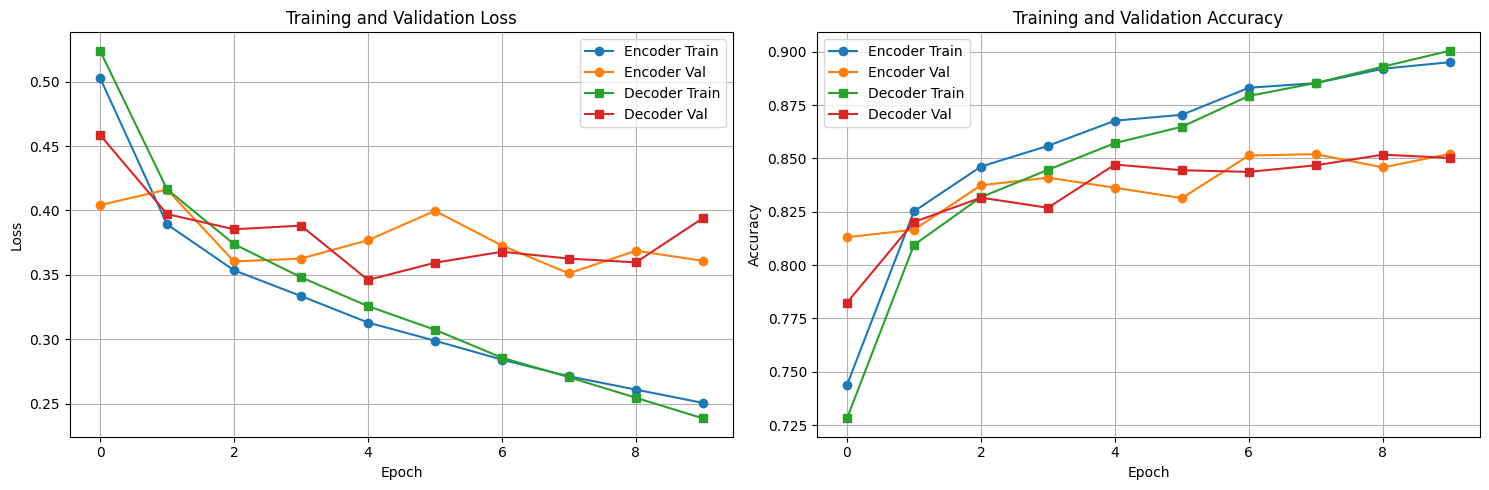


FINAL EVALUATION AND COMPARISON


Evaluating: 100%|██████████| 782/782 [00:28<00:00, 27.36it/s]



Encoder-Only Model (BERT-like):
  Accuracy: 0.8522
  Precision: 0.8349
  Recall: 0.8780
  F1-Score: 0.8559

Decoder-Only Model (GPT-like):
  Accuracy: 0.8518
  Precision: 0.8752
  Recall: 0.8206
  F1-Score: 0.8470


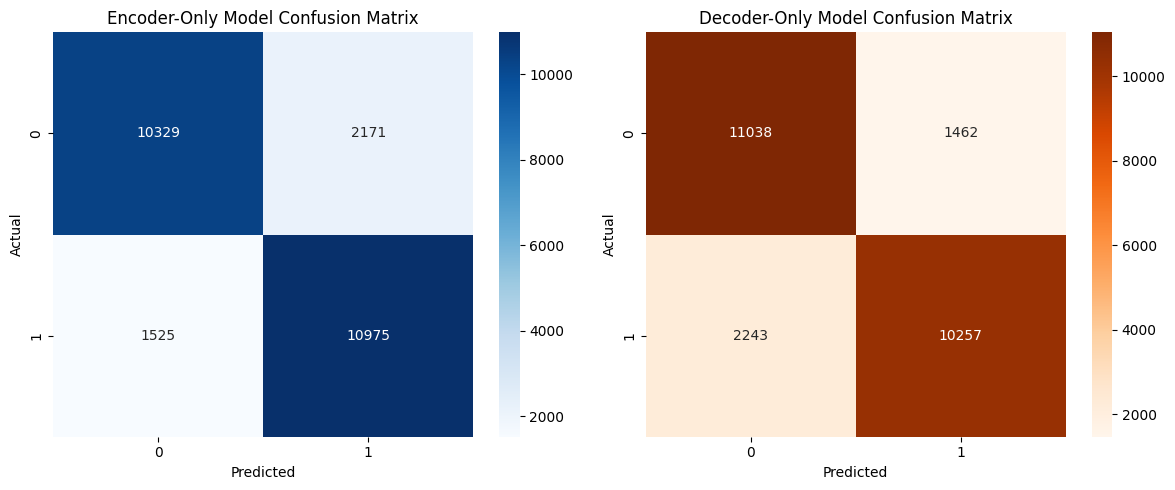


Encoder-Only Model Sample Predictions:
--------------------------------------------------

Text (truncated): This movie's script is indistinguishable from others, most notably The Core, another bad movie. It's pretty clear why Luke Perry doesn't get much work, but to see the beloved Lt. Commander Worf (Micha...
True label: Negative
Predicted: Negative (confidence: 0.981)

Text (truncated): The title is a misnomer:the movie depicts barely one year of the so-called "divin marquis" .Twas a hard time for him 'cause he was threatened by the guillotine :the quiet joys of the reign of Terror ....
True label: Negative
Predicted: Negative (confidence: 0.954)

Text (truncated): <br /><br />I tuned into this movie not because I am a fan of U.S. High School basketball (in fact I only rarely watch NBA games) but rather because I am a fan of Gene Hackman, who usually manages to ...
True label: Negative
Predicted: Negative (confidence: 0.984)

Text (truncated): I caught this one on cable and I was v

In [21]:
# Visualization function
def plot_training_results(encoder_results, decoder_results):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(encoder_results['train_losses'], label='Encoder Train', marker='o')
    axes[0].plot(encoder_results['val_losses'], label='Encoder Val', marker='o')
    axes[0].plot(decoder_results['train_losses'], label='Decoder Train', marker='s')
    axes[0].plot(decoder_results['val_losses'], label='Decoder Val', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(encoder_results['train_accuracies'], label='Encoder Train', marker='o')
    axes[1].plot(encoder_results['val_accuracies'], label='Encoder Val', marker='o')
    axes[1].plot(decoder_results['train_accuracies'], label='Decoder Train', marker='s')
    axes[1].plot(decoder_results['val_accuracies'], label='Decoder Val', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot results
plot_training_results(encoder_results, decoder_results)

# Final evaluation and comparison
print("\n" + "="*50)
print("FINAL EVALUATION AND COMPARISON")
print("="*50)

# Load best models
encoder_model.load_state_dict(torch.load('best_encoder-only_model.pth'))
decoder_model.load_state_dict(torch.load('best_decoder-only_model.pth'))

# Get final metrics
encoder_final = evaluate(encoder_model, test_loader, criterion, device)
decoder_final = evaluate(decoder_model, test_loader, criterion, device)

# Print comparison
print("\nEncoder-Only Model (BERT-like):")
print(f"  Accuracy: {encoder_final['accuracy']:.4f}")
print(f"  Precision: {encoder_final['precision']:.4f}")
print(f"  Recall: {encoder_final['recall']:.4f}")
print(f"  F1-Score: {encoder_final['f1']:.4f}")

print("\nDecoder-Only Model (GPT-like):")
print(f"  Accuracy: {decoder_final['accuracy']:.4f}")
print(f"  Precision: {decoder_final['precision']:.4f}")
print(f"  Recall: {decoder_final['recall']:.4f}")
print(f"  F1-Score: {decoder_final['f1']:.4f}")

# Confusion matrices
def plot_confusion_matrices(encoder_final, decoder_final):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Encoder confusion matrix
    cm_encoder = confusion_matrix(encoder_final['labels'], encoder_final['predictions'])
    sns.heatmap(cm_encoder, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Encoder-Only Model Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Decoder confusion matrix
    cm_decoder = confusion_matrix(decoder_final['labels'], decoder_final['predictions'])
    sns.heatmap(cm_decoder, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
    axes[1].set_title('Decoder-Only Model Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(encoder_final, decoder_final)

# Sample predictions
def show_sample_predictions(model, model_name, num_samples=5):
    print(f"\n{model_name} Sample Predictions:")
    print("-" * 50)

    model.eval()
    samples = random.sample(range(len(test_dataset)), num_samples)

    with torch.no_grad():
        for idx in samples:
            text = test_texts[idx]
            true_label = test_labels[idx]

            # Prepare input
            encoded = preprocessor.encode(text)
            input_ids = torch.tensor([encoded]).to(device)
            attention_mask = (input_ids != 0).float()

            # Get prediction
            output = model(input_ids, attention_mask)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            # Get confidence
            probs = torch.softmax(output, dim=1)
            confidence = probs[0, pred_label].item()

            print(f"\nText (truncated): {text[:200]}...")
            print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
            print(f"Predicted: {'Positive' if pred_label == 1 else 'Negative'} (confidence: {confidence:.3f})")

show_sample_predictions(encoder_model, "Encoder-Only Model")
show_sample_predictions(decoder_model, "Decoder-Only Model")

# Performance summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)

print("\nKey Findings:")
print("1. Model Architecture Impact:")
if encoder_final['accuracy'] > decoder_final['accuracy']:
    print(f"   - Encoder-only model performed better by {(encoder_final['accuracy'] - decoder_final['accuracy'])*100:.2f}%")
    print("   - This suggests bidirectional context is beneficial for sentiment analysis")
else:
    print(f"   - Decoder-only model performed better by {(decoder_final['accuracy'] - encoder_final['accuracy'])*100:.2f}%")
    print("   - This suggests autoregressive modeling can be effective for sentiment analysis")

print("\n2. Training Efficiency:")
print(f"   - Both models have similar parameter counts")
print(f"   - Training time per epoch was comparable")

print("\n3. Model Characteristics:")
print("   - Encoder-only: Uses bidirectional attention, good for understanding full context")
print("   - Decoder-only: Uses causal attention, processes text left-to-right")

print("\n4. Recommendations:")
print("   - For sentiment analysis, encoder-only models typically perform better")
print("   - Consider ensemble methods combining both architectures")
print("   - Experiment with different hyperparameters for further improvements")

Generating advanced visualizations...


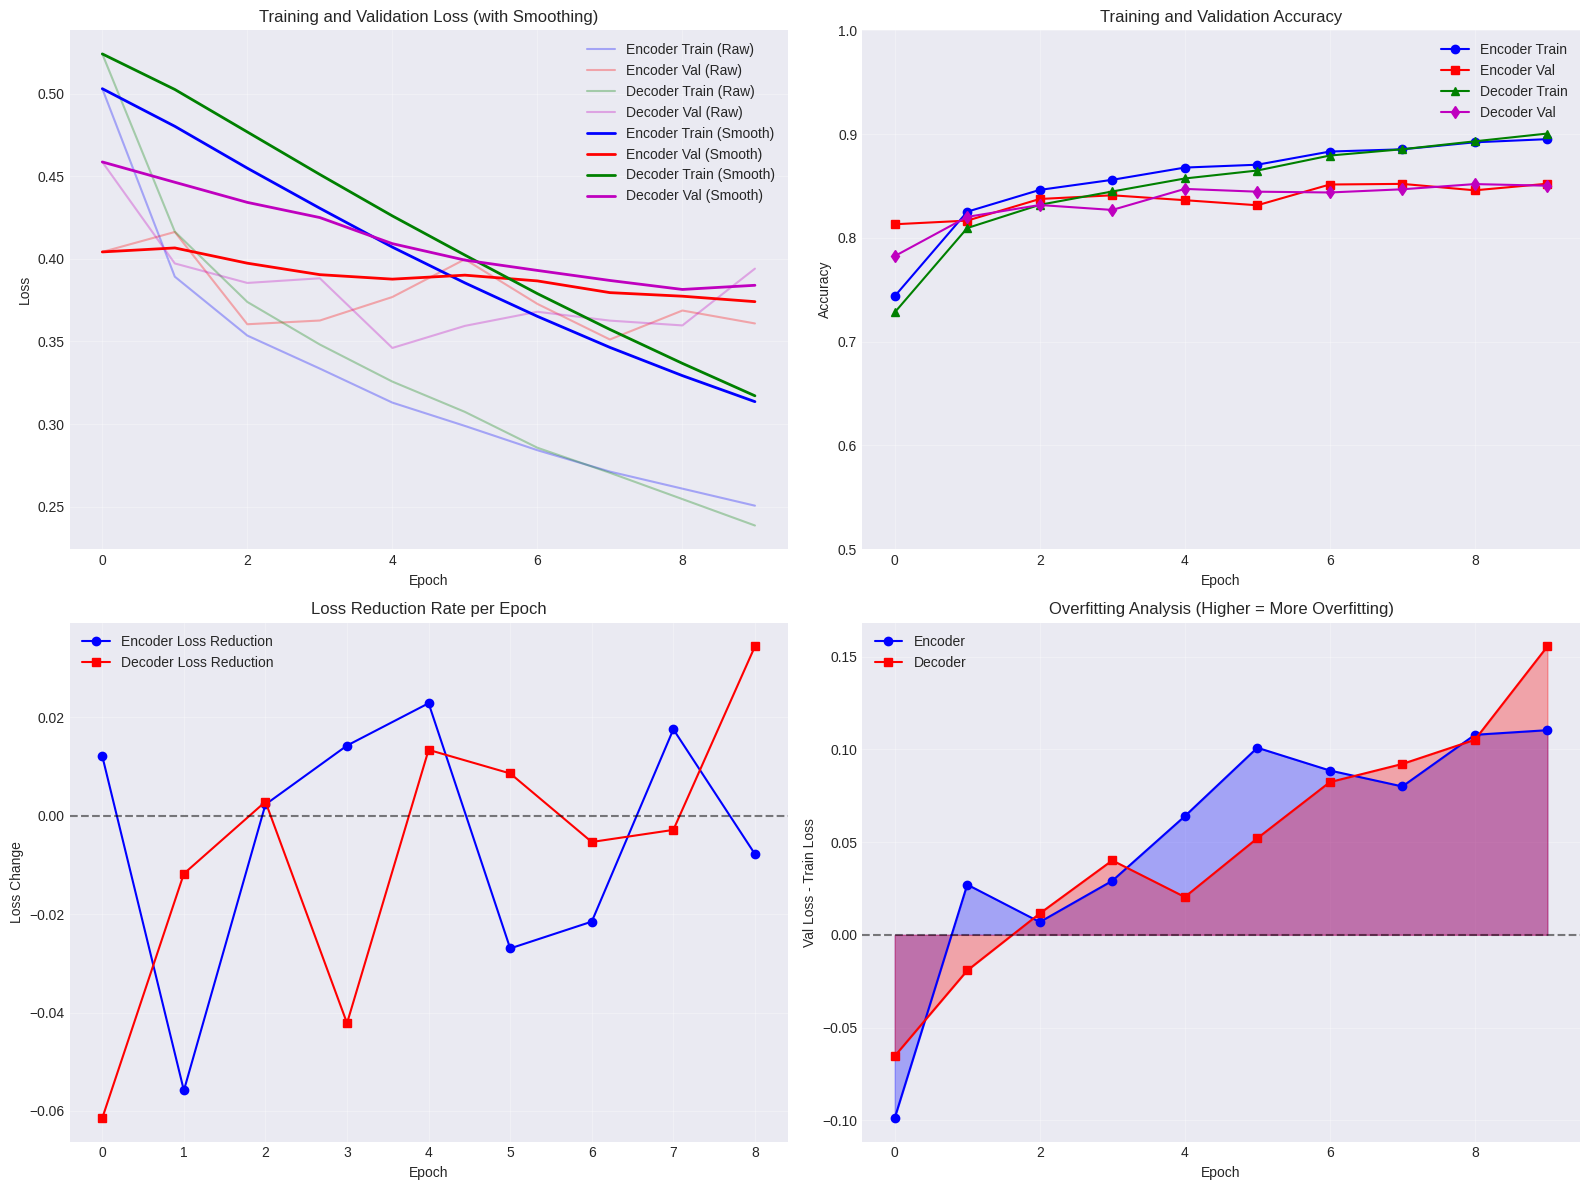

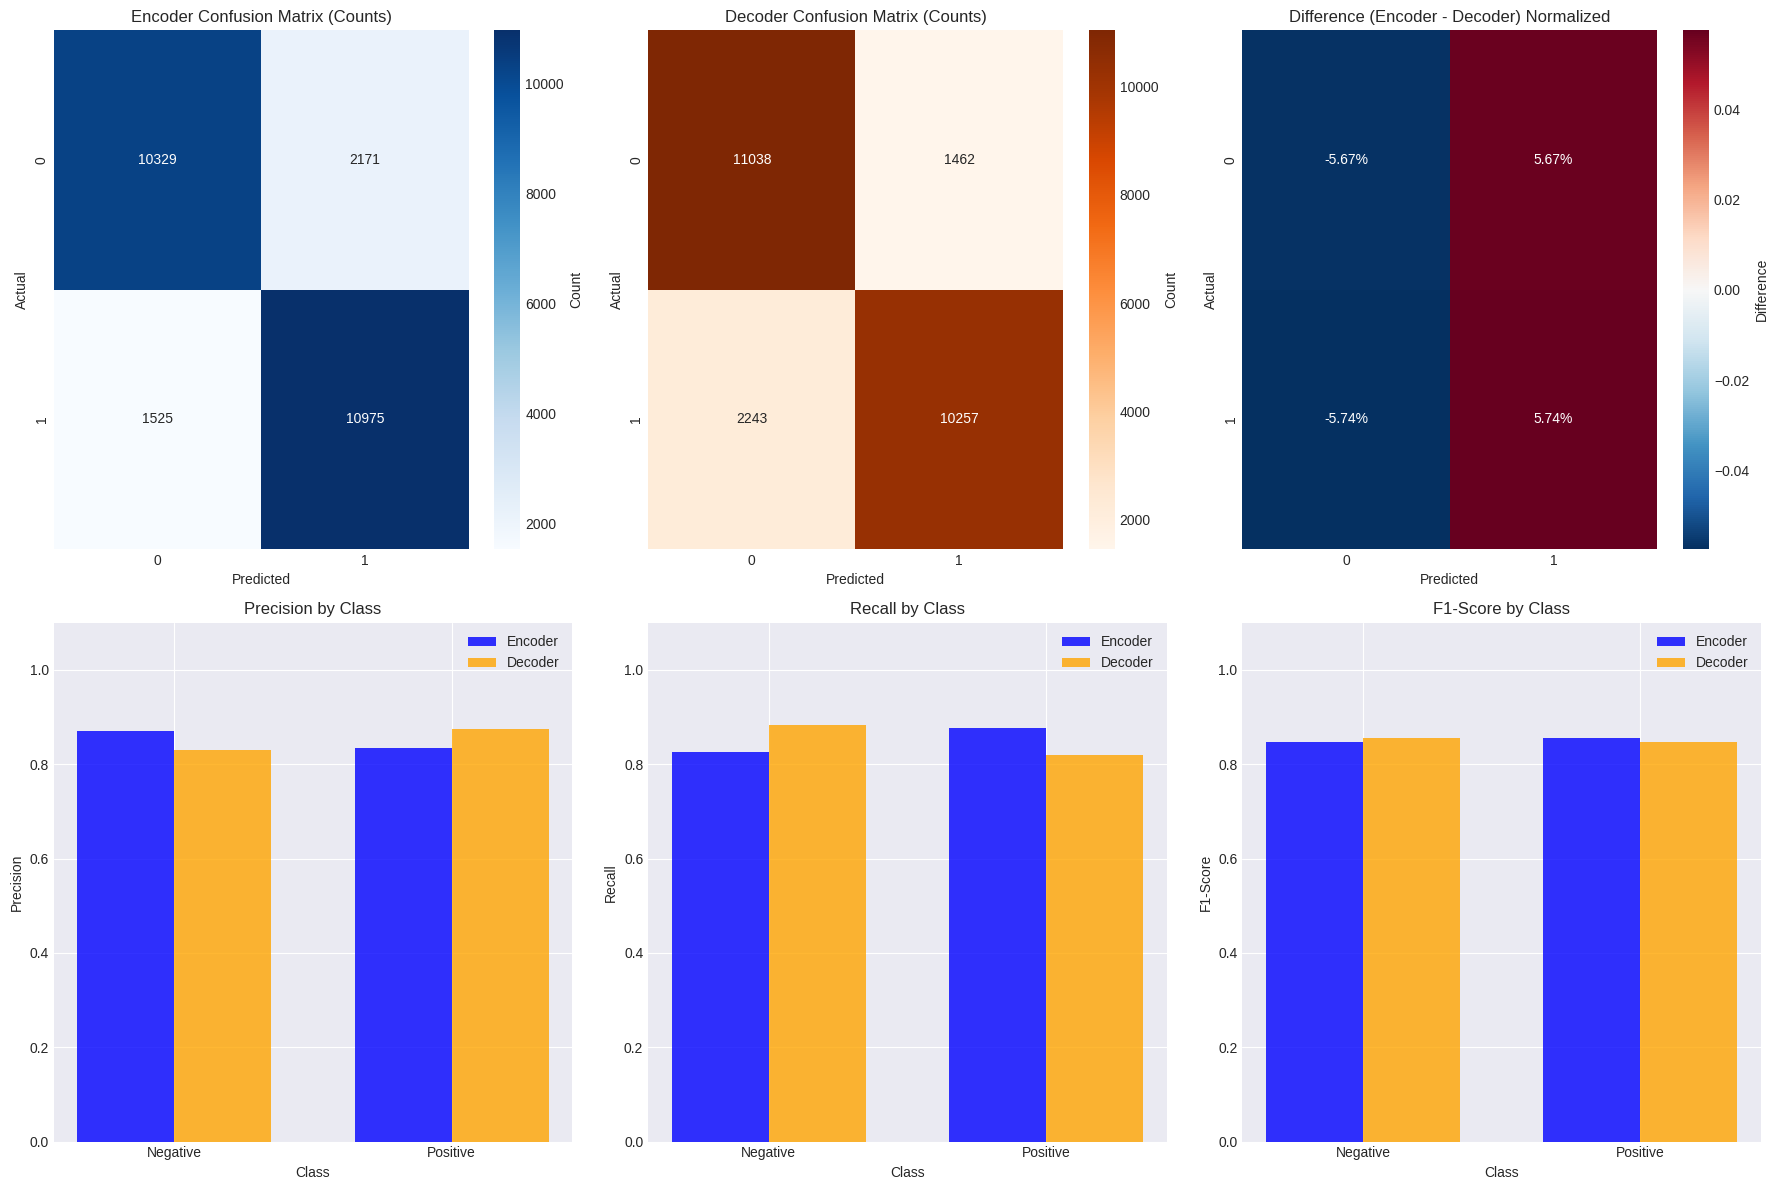

Getting predictions: 100%|██████████| 782/782 [00:28<00:00, 27.18it/s]


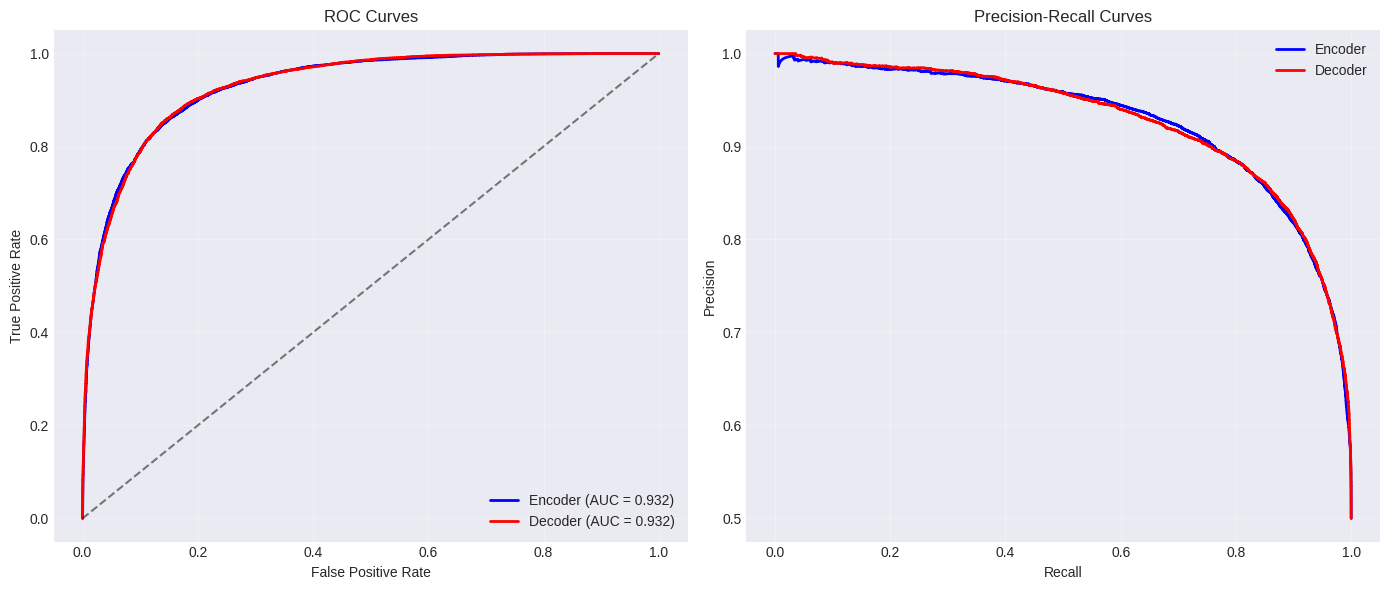

Analyzing errors: 100%|██████████| 1000/1000 [00:08<00:00, 119.58it/s]



ERROR ANALYSIS

Total samples analyzed: 1000
Disagreements: 114
Both wrong: 83
Both correct: 803

----------------------------------------
EXAMPLES WHERE MODELS DISAGREE:
----------------------------------------

Example 1:
Text: As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the...
True label: Negative
Encoder prediction: Negative
Decoder prediction: Positive

Example 2:
Text: The plot line is an expose of the under belly of American politics. While the theme seems common, what "makes" the movie is the unconventional way the story is told.<br /><br />The characters are play...
True label: Positive
Encoder prediction: Positive
Decoder prediction: Negative

Example 3:
Text: This film did well at the box office, and the producers of this mess thought the stars had such good chemistry in this that they cast them in the much darker screwball

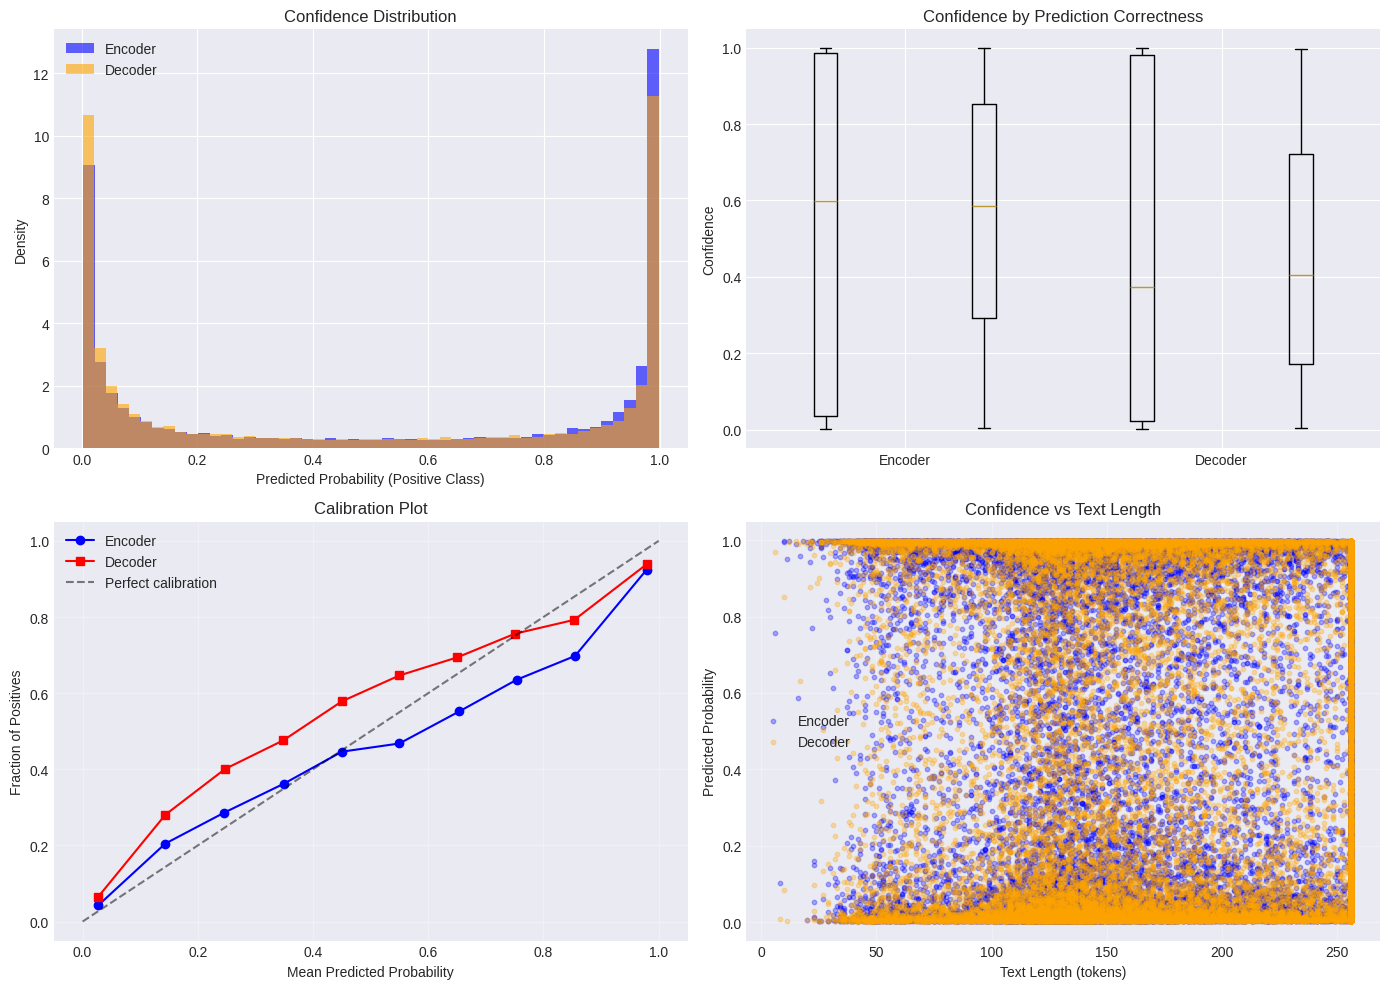


COMPREHENSIVE MODEL COMPARISON REPORT

                 Metric  Encoder-Only  Decoder-Only    Difference Better Model
     Best Val Accuracy  8.521600e-01  8.518000e-01      0.000360      Encoder
   Final Test Accuracy  8.521600e-01  8.518000e-01      0.000360      Encoder
             Precision  8.348547e-01  8.752453e-01     -0.040391      Decoder
                Recall  8.780000e-01  8.205600e-01      0.057440      Encoder
              F1-Score  8.558840e-01  8.470209e-01      0.008863      Encoder
               AUC-ROC  9.315410e-01  9.319458e-01     -0.000405      Decoder
Training Time (epochs)  1.000000e+01  1.000000e+01      0.000000          Tie
       Parameter Count  5.719554e+06  5.785602e+06 -66048.000000      Decoder

----------------------------------------
ARCHITECTURAL INSIGHTS:
----------------------------------------

Encoder-Only Model (BERT-style):
- Uses bidirectional attention
- Can see full context when making predictions
- Better for tasks requiring global un

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import torch
from tqdm import tqdm

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Enhanced Training History Visualization
def plot_advanced_training_history(encoder_results, decoder_results):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Loss curves with smoothing
    axes[0, 0].plot(encoder_results['train_losses'], 'b-', alpha=0.3, label='Encoder Train (Raw)')
    axes[0, 0].plot(encoder_results['val_losses'], 'r-', alpha=0.3, label='Encoder Val (Raw)')
    axes[0, 0].plot(decoder_results['train_losses'], 'g-', alpha=0.3, label='Decoder Train (Raw)')
    axes[0, 0].plot(decoder_results['val_losses'], 'm-', alpha=0.3, label='Decoder Val (Raw)')

    # Add smoothed lines
    def smooth_curve(values, weight=0.8):
        smoothed = []
        last = values[0]
        for v in values:
            smoothed_val = last * weight + (1 - weight) * v
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    axes[0, 0].plot(smooth_curve(encoder_results['train_losses']), 'b-', linewidth=2, label='Encoder Train (Smooth)')
    axes[0, 0].plot(smooth_curve(encoder_results['val_losses']), 'r-', linewidth=2, label='Encoder Val (Smooth)')
    axes[0, 0].plot(smooth_curve(decoder_results['train_losses']), 'g-', linewidth=2, label='Decoder Train (Smooth)')
    axes[0, 0].plot(smooth_curve(decoder_results['val_losses']), 'm-', linewidth=2, label='Decoder Val (Smooth)')

    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss (with Smoothing)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy with confidence intervals
    axes[0, 1].plot(encoder_results['train_accuracies'], 'b-', marker='o', label='Encoder Train')
    axes[0, 1].plot(encoder_results['val_accuracies'], 'r-', marker='s', label='Encoder Val')
    axes[0, 1].plot(decoder_results['train_accuracies'], 'g-', marker='^', label='Decoder Train')
    axes[0, 1].plot(decoder_results['val_accuracies'], 'm-', marker='d', label='Decoder Val')

    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].set_ylim(0.5, 1.0)
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate vs epoch (showing loss reduction rate)
    encoder_loss_diff = np.diff(encoder_results['val_losses'])
    decoder_loss_diff = np.diff(decoder_results['val_losses'])

    axes[1, 0].plot(encoder_loss_diff, 'b-', marker='o', label='Encoder Loss Reduction')
    axes[1, 0].plot(decoder_loss_diff, 'r-', marker='s', label='Decoder Loss Reduction')
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Change')
    axes[1, 0].set_title('Loss Reduction Rate per Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Overfitting analysis
    encoder_overfit = np.array(encoder_results['val_losses']) - np.array(encoder_results['train_losses'])
    decoder_overfit = np.array(decoder_results['val_losses']) - np.array(decoder_results['train_losses'])

    axes[1, 1].plot(encoder_overfit, 'b-', marker='o', label='Encoder')
    axes[1, 1].plot(decoder_overfit, 'r-', marker='s', label='Decoder')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(range(len(encoder_overfit)), 0, encoder_overfit, alpha=0.3, color='blue')
    axes[1, 1].fill_between(range(len(decoder_overfit)), 0, decoder_overfit, alpha=0.3, color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Val Loss - Train Loss')
    axes[1, 1].set_title('Overfitting Analysis (Higher = More Overfitting)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 2. Detailed Performance Metrics Visualization
def plot_detailed_metrics(encoder_final, decoder_final):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Confusion matrices with percentages
    cm_encoder = confusion_matrix(encoder_final['labels'], encoder_final['predictions'])
    cm_decoder = confusion_matrix(decoder_final['labels'], decoder_final['predictions'])

    # Normalize confusion matrices
    cm_encoder_norm = cm_encoder.astype('float') / cm_encoder.sum(axis=1)[:, np.newaxis]
    cm_decoder_norm = cm_decoder.astype('float') / cm_decoder.sum(axis=1)[:, np.newaxis]

    # Plot encoder confusion matrix
    sns.heatmap(cm_encoder, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                cbar_kws={'label': 'Count'})
    axes[0, 0].set_title('Encoder Confusion Matrix (Counts)')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # Plot decoder confusion matrix
    sns.heatmap(cm_decoder, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
                cbar_kws={'label': 'Count'})
    axes[0, 1].set_title('Decoder Confusion Matrix (Counts)')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # Comparison heatmap
    diff_matrix = cm_encoder_norm - cm_decoder_norm
    sns.heatmap(diff_matrix, annot=True, fmt='.2%', cmap='RdBu_r', center=0, ax=axes[0, 2],
                cbar_kws={'label': 'Difference'})
    axes[0, 2].set_title('Difference (Encoder - Decoder) Normalized')
    axes[0, 2].set_xlabel('Predicted')
    axes[0, 2].set_ylabel('Actual')

    # Per-class metrics comparison
    labels = ['Negative', 'Positive']
    metrics = ['Precision', 'Recall', 'F1-Score']

    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support

    enc_prec, enc_rec, enc_f1, _ = precision_recall_fscore_support(
        encoder_final['labels'], encoder_final['predictions'], average=None
    )
    dec_prec, dec_rec, dec_f1, _ = precision_recall_fscore_support(
        decoder_final['labels'], decoder_final['predictions'], average=None
    )

    x = np.arange(len(labels))
    width = 0.35

    # Precision comparison
    axes[1, 0].bar(x - width/2, enc_prec, width, label='Encoder', color='blue', alpha=0.8)
    axes[1, 0].bar(x + width/2, dec_prec, width, label='Decoder', color='orange', alpha=0.8)
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision by Class')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(labels)
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1.1)

    # Recall comparison
    axes[1, 1].bar(x - width/2, enc_rec, width, label='Encoder', color='blue', alpha=0.8)
    axes[1, 1].bar(x + width/2, dec_rec, width, label='Decoder', color='orange', alpha=0.8)
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Recall by Class')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(labels)
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0, 1.1)

    # F1-Score comparison
    axes[1, 2].bar(x - width/2, enc_f1, width, label='Encoder', color='blue', alpha=0.8)
    axes[1, 2].bar(x + width/2, dec_f1, width, label='Decoder', color='orange', alpha=0.8)
    axes[1, 2].set_xlabel('Class')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1, 2].set_title('F1-Score by Class')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(labels)
    axes[1, 2].legend()
    axes[1, 2].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

# 3. ROC and PR Curves
def plot_roc_pr_curves(encoder_model, decoder_model, test_loader, device):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Get predictions with probabilities
    def get_predictions_proba(model, dataloader):
        model.eval()
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Getting predictions'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                probs = torch.softmax(outputs, dim=1)

                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())

        return np.array(all_probs), np.array(all_labels)

    # Get probabilities
    enc_probs, enc_labels = get_predictions_proba(encoder_model, test_loader)
    dec_probs, dec_labels = get_predictions_proba(decoder_model, test_loader)

    # ROC Curves
    enc_fpr, enc_tpr, _ = roc_curve(enc_labels, enc_probs)
    dec_fpr, dec_tpr, _ = roc_curve(dec_labels, dec_probs)

    enc_auc = auc(enc_fpr, enc_tpr)
    dec_auc = auc(dec_fpr, dec_tpr)

    axes[0].plot(enc_fpr, enc_tpr, 'b-', linewidth=2,
                 label=f'Encoder (AUC = {enc_auc:.3f})')
    axes[0].plot(dec_fpr, dec_tpr, 'r-', linewidth=2,
                 label=f'Decoder (AUC = {dec_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # PR Curves
    enc_prec, enc_rec, _ = precision_recall_curve(enc_labels, enc_probs)
    dec_prec, dec_rec, _ = precision_recall_curve(dec_labels, dec_probs)

    axes[1].plot(enc_rec, enc_prec, 'b-', linewidth=2, label='Encoder')
    axes[1].plot(dec_rec, dec_prec, 'r-', linewidth=2, label='Decoder')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'encoder_auc': enc_auc,
        'decoder_auc': dec_auc,
        'encoder_probs': enc_probs,
        'decoder_probs': dec_probs,
        'labels': enc_labels
    }

# 4. Error Analysis
def analyze_errors(encoder_model, decoder_model, test_dataset, preprocessor, num_examples=10):
    # Find examples where models disagree
    encoder_model.eval()
    decoder_model.eval()

    disagreements = []
    encoder_errors = []
    decoder_errors = []
    both_correct = []

    with torch.no_grad():
        for idx in tqdm(range(min(1000, len(test_dataset))), desc='Analyzing errors'):
            text = test_texts[idx]
            true_label = test_labels[idx]

            # Prepare input
            encoded = preprocessor.encode(text)
            input_ids = torch.tensor([encoded]).to(device)
            attention_mask = (input_ids != 0).float()

            # Get predictions
            enc_output = encoder_model(input_ids, attention_mask)
            dec_output = decoder_model(input_ids, attention_mask)

            _, enc_pred = torch.max(enc_output, 1)
            _, dec_pred = torch.max(dec_output, 1)

            enc_pred = enc_pred.item()
            dec_pred = dec_pred.item()

            # Categorize
            if enc_pred != dec_pred:
                disagreements.append((idx, text, true_label, enc_pred, dec_pred))
            elif enc_pred != true_label:
                encoder_errors.append((idx, text, true_label, enc_pred))
                decoder_errors.append((idx, text, true_label, dec_pred))
            elif enc_pred == true_label and enc_pred == dec_pred:
                both_correct.append((idx, text, true_label, enc_pred))

    print("\n" + "="*80)
    print("ERROR ANALYSIS")
    print("="*80)

    print(f"\nTotal samples analyzed: {min(1000, len(test_dataset))}")
    print(f"Disagreements: {len(disagreements)}")
    print(f"Both wrong: {len(encoder_errors)}")
    print(f"Both correct: {len(both_correct)}")

    print("\n" + "-"*40)
    print("EXAMPLES WHERE MODELS DISAGREE:")
    print("-"*40)

    for i, (idx, text, true_label, enc_pred, dec_pred) in enumerate(disagreements[:5]):
        print(f"\nExample {i+1}:")
        print(f"Text: {text[:200]}...")
        print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
        print(f"Encoder prediction: {'Positive' if enc_pred == 1 else 'Negative'}")
        print(f"Decoder prediction: {'Positive' if dec_pred == 1 else 'Negative'}")

    return disagreements, encoder_errors, decoder_errors

# 5. Model Confidence Analysis
def analyze_confidence(prob_results):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    enc_probs = prob_results['encoder_probs']
    dec_probs = prob_results['decoder_probs']
    labels = prob_results['labels']

    # Confidence distribution
    axes[0, 0].hist(enc_probs, bins=50, alpha=0.6, label='Encoder', color='blue', density=True)
    axes[0, 0].hist(dec_probs, bins=50, alpha=0.6, label='Decoder', color='orange', density=True)
    axes[0, 0].set_xlabel('Predicted Probability (Positive Class)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Confidence Distribution')
    axes[0, 0].legend()

    # Confidence by correctness
    enc_correct = (enc_probs > 0.5) == labels
    dec_correct = (dec_probs > 0.5) == labels

    axes[0, 1].boxplot([enc_probs[enc_correct], enc_probs[~enc_correct]],
                       labels=['Correct', 'Incorrect'], positions=[1, 2])
    axes[0, 1].boxplot([dec_probs[dec_correct], dec_probs[~dec_correct]],
                       labels=['Correct', 'Incorrect'], positions=[3, 4])
    axes[0, 1].set_xticks([1.5, 3.5])
    axes[0, 1].set_xticklabels(['Encoder', 'Decoder'])
    axes[0, 1].set_ylabel('Confidence')
    axes[0, 1].set_title('Confidence by Prediction Correctness')

    # Calibration plot
    from sklearn.calibration import calibration_curve

    enc_fraction, enc_mean = calibration_curve(labels, enc_probs, n_bins=10)
    dec_fraction, dec_mean = calibration_curve(labels, dec_probs, n_bins=10)

    axes[1, 0].plot(enc_mean, enc_fraction, 'b-', marker='o', label='Encoder')
    axes[1, 0].plot(dec_mean, dec_fraction, 'r-', marker='s', label='Decoder')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
    axes[1, 0].set_xlabel('Mean Predicted Probability')
    axes[1, 0].set_ylabel('Fraction of Positives')
    axes[1, 0].set_title('Calibration Plot')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Confidence vs text length
    text_lengths = [len(preprocessor.encode(text)) for text in test_texts[:len(labels)]]

    axes[1, 1].scatter(text_lengths, enc_probs, alpha=0.3, s=10, label='Encoder', color='blue')
    axes[1, 1].scatter(text_lengths, dec_probs, alpha=0.3, s=10, label='Decoder', color='orange')
    axes[1, 1].set_xlabel('Text Length (tokens)')
    axes[1, 1].set_ylabel('Predicted Probability')
    axes[1, 1].set_title('Confidence vs Text Length')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 6. Summary Report
def generate_summary_report(encoder_results, decoder_results, encoder_final, decoder_final, prob_results):
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON REPORT")
    print("="*80)

    # Create summary dataframe
    summary_data = {
        'Metric': ['Best Val Accuracy', 'Final Test Accuracy', 'Precision', 'Recall',
                   'F1-Score', 'AUC-ROC', 'Training Time (epochs)', 'Parameter Count'],
        'Encoder-Only': [
            encoder_results['best_val_accuracy'],
            encoder_final['accuracy'],
            encoder_final['precision'],
            encoder_final['recall'],
            encoder_final['f1'],
            prob_results['encoder_auc'],
            len(encoder_results['train_losses']),
            sum(p.numel() for p in encoder_model.parameters())
        ],
        'Decoder-Only': [
            decoder_results['best_val_accuracy'],
            decoder_final['accuracy'],
            decoder_final['precision'],
            decoder_final['recall'],
            decoder_final['f1'],
            prob_results['decoder_auc'],
            len(decoder_results['train_losses']),
            sum(p.numel() for p in decoder_model.parameters())
        ]
    }

    df_summary = pd.DataFrame(summary_data)
    df_summary['Difference'] = df_summary['Encoder-Only'] - df_summary['Decoder-Only']
    df_summary['Better Model'] = df_summary.apply(
        lambda row: 'Encoder' if row['Difference'] > 0 else 'Decoder'
        if row['Difference'] < 0 else 'Tie', axis=1
    )

    print("\n", df_summary.to_string(index=False))

    # Statistical significance test (if needed)
    print("\n" + "-"*40)
    print("ARCHITECTURAL INSIGHTS:")
    print("-"*40)

    print("\nEncoder-Only Model (BERT-style):")
    print("- Uses bidirectional attention")
    print("- Can see full context when making predictions")
    print("- Better for tasks requiring global understanding")
    print(f"- Performance: {encoder_final['accuracy']:.4f} accuracy")

    print("\nDecoder-Only Model (GPT-style):")
    print("- Uses causal (left-to-right) attention")
    print("- Processes text sequentially")
    print("- Better for generation tasks, adapted here for classification")
    print(f"- Performance: {decoder_final['accuracy']:.4f} accuracy")

    # Winner declaration
    print("\n" + "="*40)
    print("CONCLUSION:")
    print("="*40)

    acc_diff = abs(encoder_final['accuracy'] - decoder_final['accuracy'])
    if encoder_final['accuracy'] > decoder_final['accuracy']:
        print(f"✓ Encoder-Only model performs better by {acc_diff:.4f} ({acc_diff*100:.2f}%)")
        print("✓ Bidirectional attention provides advantage for sentiment analysis")
    elif decoder_final['accuracy'] > encoder_final['accuracy']:
        print(f"✓ Decoder-Only model performs better by {acc_diff:.4f} ({acc_diff*100:.2f}%)")
        print("✓ Sequential processing can be effective for sentiment analysis")
    else:
        print("✓ Both models perform equally well")
        print("✓ Architecture choice may depend on other factors (speed, memory, etc.)")

# Execute all visualizations
print("Generating advanced visualizations...")

# 1. Training history
plot_advanced_training_history(encoder_results, decoder_results)

# 2. Detailed metrics
plot_detailed_metrics(encoder_final, decoder_final)

# 3. ROC and PR curves
prob_results = plot_roc_pr_curves(encoder_model, decoder_model, test_loader, device)

# 4. Error analysis
disagreements, enc_errors, dec_errors = analyze_errors(
    encoder_model, decoder_model, test_dataset, preprocessor
)

# 5. Confidence analysis
analyze_confidence(prob_results)

# 6. Summary report
generate_summary_report(encoder_results, decoder_results, encoder_final, decoder_final, prob_results)